In [1]:
# Environment and cache setup
import os
from pathlib import Path
import sys

# Prefer absolute paths on the cluster
PROJECT_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation').resolve()
DATA_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation').resolve()
NOTEBOOK_DIR = PROJECT_ROOT / 'notebooks'
DATA_DIR = DATA_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'geneformer' / 'prostate_baseline'
MODEL_OUT = OUTPUT_DIR / 'model_outputs'
CACHE_DIR = NOTEBOOK_DIR / 'cache'

# Ensure local package imports work
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

for p in [OUTPUT_DIR, MODEL_OUT, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Set environment variables for local cache directories
os.environ['PIP_CACHE_DIR'] = str(CACHE_DIR / 'pip')
os.environ['HF_HOME'] = str(CACHE_DIR / 'huggingface')
os.environ['TRANSFORMERS_CACHE'] = str(CACHE_DIR / 'transformers')
os.environ['MPLCONFIGDIR'] = str(CACHE_DIR / 'matplotlib')

print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('DATA_DIR:', DATA_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('MODEL_OUT:', MODEL_OUT)


PROJECT_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation
DATA_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation
DATA_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data
OUTPUT_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline
MODEL_OUT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs


In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
# Paths and dataset config (prostate)
from pathlib import Path

in_dataset_path = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/prostate_cancer_with_celltypes_v3.h5ad')
dataset_name = in_dataset_path.stem
preprocessed_path = (DATA_DIR / 'geneformer' / (dataset_name + '_full_model_v1')).resolve()
preprocessed_path.mkdir(parents=True, exist_ok=True)

# Placeholders; will be finalized after inspection cells
gene_col = 'gene_symbols'
batch_col = 'sample'     # to be validated
label_col = 'cell_type'  # to be validated
layer_key = 'X'

RUN_TAG = 'full'

model_dir = (PROJECT_ROOT / 'Geneformer' / 'Geneformer-V1-10M').resolve()
dict_dir = (PROJECT_ROOT / 'Geneformer' / 'geneformer').resolve()

print('in_dataset_path:', in_dataset_path)
print('preprocessed_path:', preprocessed_path)
print('model_dir:', model_dir)
print('dict_dir:', dict_dir)


in_dataset_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/prostate_cancer_with_celltypes_v3.h5ad
preprocessed_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_full_model_v1
model_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M
dict_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/geneformer


In [4]:
# Create Geneformer instance and load model/vocab
batch_size = 16
num_workers = -1

geneform = gf.Geneformer_instance(
    save_dir=str(OUTPUT_DIR),
    saved_model_path=str(model_dir),
    explicit_save_dir=True,
    num_workers=num_workers
)

geneform.load_pretrained_model()
geneform.load_vocab(str(dict_dir))


INFO     | 2025-08-21 00:11:59 | Using device cuda


INFO     | 2025-08-21 00:11:59 | Model successfully loaded from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M


In [5]:
# Inspect dataset to determine columns and structure
import scanpy as sc
ad = sc.read_h5ad(str(in_dataset_path))

print('adata shape:', ad.shape)
print('obs columns:', list(ad.obs.columns)[:50])
print('var columns:', list(ad.var.columns)[:50])

candidate_label_cols = [c for c in ad.obs.columns if c.lower() in ['cell_type','celltype','celltypes','cell_label','celltype_major','major_cell_type','cell_types','annot','annotation','celltype_annotation']]
if candidate_label_cols:
    label_col = candidate_label_cols[0]
print('label_col ->', label_col)

candidate_batch_cols = [c for c in ad.obs.columns if c.lower() in ['sample','batch','patient','donor','sample_id','batch_id','subject','study']]
if candidate_batch_cols:
    batch_col = candidate_batch_cols[0]
print('batch_col ->', batch_col)

if 'gene_symbols' in ad.var.columns:
    gene_col = 'gene_symbols'
else:
    gene_col = None
print('gene_col ->', gene_col if gene_col else 'var.index')

print('n unique labels:', ad.obs[label_col].nunique() if label_col in ad.obs else 'NA')
print('label example counts:\n', ad.obs[label_col].astype(str).value_counts().head(20) if label_col in ad.obs else 'NA')


adata shape: (36424, 25044)
obs columns: ['sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'sample_technology', 'sample_n_cells', 'sample_patient', 'sample_cancer_type', 'sample_sex', 'sample_age', 'sample_smoking_status', 'sample_PY', 'sample_diagnosis_recurrence', 'sample_disease_extent', 'sample_AJCC_T', 'sample_AJCC_N', 'sample_AJCC_M', 'sample_AJCC_stage', 'sample_sample_primary_met', 'sample_size', 'sample_site', 'sample_histology', 'sample_genetic_hormonal_features', 'sample_grade', 'sample_KI67', 'sample_treated_naive', 'sample_chemotherapy_exposed', 'sample_chemotherapy_response', 'sample_targeted_rx_exposed', 'sample_targeted_rx_response', 'sample_ICB_exposed', 'sample_ICB_response', 'sample_ET_exposed', 'sample_ET_response', 'sample_time_end_of_rx_to_sampling', 'sample_post_sampling_rx_exposed', 'sample_post_sampling_rx_response', 'sample_PFS_DFS', 'sample_OS', 'n_genes_by_counts',

In [6]:
# Load and preprocess data to h5ad for tokenizer
inp = data.InputData(adata_dataset_path=str(in_dataset_path))

inp.preprocess_data(
    gene_col=gene_col if gene_col else 'index',
    model_type='geneformer',
    save_ext='h5ad',
    gene_name_id_dict=geneform.gene_name_id,
    preprocessed_path=str(preprocessed_path)
)

h5_path = preprocessed_path / f'{dataset_name}_full_model_v1.h5ad'
print('h5_path:', h5_path, 'exists:', h5_path.exists())


INFO     | 2025-08-21 00:12:09 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/prostate_cancer_with_celltypes_v3.h5ad
WARNING  | 2025-08-21 00:12:17 | Gene names not found in var columns. Using index instead.
INFO     | 2025-08-21 00:12:21 | Matched 76.10% genes (16593/21804) genes in vocabulary of size 63675.


h5_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_full_model_v1/prostate_cancer_with_celltypes_v3_full_model_v1.h5ad exists: False


In [7]:
# Verify/update columns post-preprocess
import scanpy as sc
pfile = str(preprocessed_path / f'{dataset_name}.h5ad')

ad_tmp = sc.read(pfile)
if 'cell_type' not in ad_tmp.obs.columns and label_col in ad_tmp.obs.columns:
    ad_tmp.obs['cell_type'] = ad_tmp.obs[label_col].astype(str).values
    print("Added 'cell_type' column from:", label_col)
if 'adata_order' not in ad_tmp.obs.columns:
    ad_tmp.obs['adata_order'] = ad_tmp.obs.index.astype(str).values

ad_tmp.write(pfile)
print('Verified/updated columns in preprocessed file:', pfile)


Verified/updated columns in preprocessed file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_full_model_v1/prostate_cancer_with_celltypes_v3.h5ad


In [10]:
# Tokenize to HF Dataset on disk and persist

geneform.tokenize_data(
    adata_path=str(h5_path),
    dataset_path=str(preprocessed_path),
    cell_type_col=label_col
)

# TRUNCATION - Applied immediately after tokenization
print("=== APPLYING TRUNCATION TO TOKENIZED SEQUENCES ===")

# Truncate sequences to 2048 tokens to fit model limits
def truncate_sequences(example):
    # Force all sequences to be exactly 2048 tokens
    if len(example["input_ids"]) > 2048:
        example["input_ids"] = example["input_ids"][:2048]
    elif len(example["input_ids"]) < 2048:
        # Pad with zeros to reach 2048
        example["input_ids"] = example["input_ids"] + [0] * (2048 - len(example["input_ids"]))
    
    example["length"] = 2048  # Always 2048
    return example

print(f"Original dataset size: {len(geneform.tokenized_dataset)}")
if len(geneform.tokenized_dataset) > 0:
    print(f"Sample input_ids length before truncation: {len(geneform.tokenized_dataset[0]['input_ids'])}")
    if 'length' in geneform.tokenized_dataset[0]:
        print(f"Sample length field before truncation: {geneform.tokenized_dataset[0]['length']}")

# Apply truncation
print("Applying truncation...")
geneform.tokenized_dataset = geneform.tokenized_dataset.map(truncate_sequences, num_proc=1)

if len(geneform.tokenized_dataset) > 0:
    print(f"Sample input_ids length after truncation: {len(geneform.tokenized_dataset[0]['input_ids'])}")
    print(f"Sample length field after truncation: {geneform.tokenized_dataset[0]['length']}")

# Verify all sequences are within limit
max_length = max([len(example['input_ids']) for example in geneform.tokenized_dataset])
print(f"Maximum sequence length after truncation: {max_length}")
if max_length > 2048:
    print("⚠️ WARNING: Some sequences are still longer than 2048!")
else:
    print("✅ All sequences are ≤ 2048 tokens")

# Avoid deletion issues by using timestamped directory
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
dataset_dir = preprocessed_path / f'{dataset_name}_full_model_v1_{timestamp}.dataset'
print(f'Using timestamped dataset directory: {dataset_dir}')

try:
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
    print('Successfully saved truncated tokenized dataset to disk.')
except Exception as e:
    print('Error saving to disk:', e)
    # Fallback: try saving with different name
    dataset_dir_fallback = preprocessed_path / f'{dataset_name}_truncated_fallback.dataset'
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir_fallback))
    print(f'Saved truncated dataset to fallback location: {dataset_dir_fallback}')
    dataset_dir = dataset_dir_fallback

try:
    order = geneform.tokenized_dataset['adata_order']
    pd.Series(order, name='adata_order').to_csv(dataset_dir / 'row_order.csv', index=False)
    print('Saved row_order.csv')
except Exception as e:
    print('Row order not available or failed to save:', e)

manifest = {
    'dataset_name': dataset_name,
    'tokenized_dir': str(dataset_dir.resolve()),
    'label_col': label_col,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open(dataset_dir / 'manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print('Saved manifest.json')

import tarfile
archive_path = MODEL_OUT / f'{dataset_name}_full_model_v1_{timestamp}.dataset.tar.gz'
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(str(dataset_dir), arcname=f'{dataset_name}.dataset')
print('Archived tokenized dataset to:', archive_path)

WARNING  | 2025-08-21 00:18:08 | using h5ad file. This sometimes causes issues. If not working try with loom.


Tokenizing /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_full_model_v1/prostate_cancer_with_celltypes_v3.h5ad
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_full_model_v1/prostate_cancer_with_celltypes_v3.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.
Number of cells: 36424
Sample input_ids length: 2393
=== APPLYING TRUNCATION TO TOKENIZED SEQUENCES ===
Original dataset size: 36424
Sample input_ids length before truncation: 2395
Sample length field before truncation: 2395
Applying truncation...
Sample input_ids length after truncation: 2048
Sample length field after truncation: 2048
Maximum sequence length after truncation: 2048
✅ All sequences are ≤ 2048 tokens
Using timestamped dataset directory: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_full_model_v1/prostate_cancer_with_c

In [11]:
# Load back, extract embeddings, and quick eval

geneform.load_tokenized_dataset(str(dataset_dir))

geneform.extract_embeddings(
    data=inp,
    batch_size=batch_size,
    layer=-2
)

eval_ce = cell_embeddings.CellEmbeddingsEval(
    geneform,
    data=inp,
    output_dir=str(MODEL_OUT),
    label_key=label_col,
    batch_key=batch_col
)

eval_pred = model_output.GeneExprPredEval(geneform, output_dir=str(MODEL_OUT))

eval_pred.evaluate(n_cells=500, save_rankings=True)
eval_ce.evaluate(n_cells=1000, embedding_key='geneformer')


Geneformer (extracting embeddings): 100%|██████████| 2277/2277 [07:45<00:00,  4.89it/s]
DEBUG    | 2025-08-21 00:30:56 | Extracting output from 500 cells
WARNING  | 2025-08-21 00:31:06 | adata_ has 36424 cells. Taking a subset of 1000 cells.
DEBUG    | 2025-08-21 00:31:06 | Computing metrics for cell_type
DEBUG    | 2025-08-21 00:31:12 | NMI_cluster/label: 0.1680
ARI_cluster/label: 0.1245
ASW_label: 0.4205
graph_conn: 0.3857
ASW_batch: 0.3561
ASW_label/batch: 0.5777
PCR_batch: 0.0296
avg_bio: 0.2377
DEBUG    | 2025-08-21 00:31:12 | NMI_cluster/label for cell_type: 0.16796778086326306
DEBUG    | 2025-08-21 00:31:12 | ARI_cluster/label for cell_type: 0.12453030603958898
DEBUG    | 2025-08-21 00:31:12 | ASW_label for cell_type: 0.42048826813697815
DEBUG    | 2025-08-21 00:31:12 | graph_conn for cell_type: 0.3857378800348392
DEBUG    | 2025-08-21 00:31:12 | ASW_batch for cell_type: 0.3560587167739868
DEBUG    | 2025-08-21 00:31:12 | ASW_label/batch for cell_type: 0.5776752233505249
DEBUG  

,metric,label,value
0,NMI_cluster/label,cell_type,0.167968
1,ARI_cluster/label,cell_type,0.124530
2,ASW_label,cell_type,0.420488
3,graph_conn,cell_type,0.385738
4,ASW_batch,cell_type,0.356059
5,ASW_label/batch,cell_type,0.577675
6,PCR_batch,cell_type,0.029605
7,avg_bio,cell_type,0.237662


In [12]:
# Ensemble evaluation and saving
em = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=inp,
    label_col=label_col,
    output_dir=str(MODEL_OUT)
)

alphas = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
results = {}
for alpha in alphas:
    try:
        res = em.evaluate_ensemble(alpha=alpha, method='embedding_only')
        results[alpha] = res
        print(f"alpha={alpha}: F1={res['f1_score']:.3f}, AUC={res['auc_roc']:.3f}, Acc={res['accuracy']:.3f}")
    except Exception as e:
        print('Failed for alpha', alpha, ':', e)

best_alpha = max(results, key=lambda a: results[a]['f1_score'])
best_res = results[best_alpha]

preds, scores = em.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')

save_dict = {
    'cell_embs': torch.tensor(em.embeddings, dtype=torch.float32),
    'logits': torch.tensor(scores, dtype=torch.float32),
    'preds': torch.tensor(preds, dtype=torch.long),
    'labels': torch.tensor(em.labels_encoded, dtype=torch.long),
    'class_names': em.class_names,
    'best_alpha': best_alpha,
    'model_name': 'Geneformer-V1-10M',
    'dataset_name': dataset_name,
    'embedding_dim': int(em.embeddings.shape[1]),
    'n_cells': int(len(em.embeddings)),
    'n_classes': int(len(em.class_names)),
    'evaluation_date': datetime.now().isoformat(),
    'evaluation_metrics': best_res
}

results_path = MODEL_OUT / f'geneformer_prostate_results_model_v1_{RUN_TAG}.pt'
torch.save(save_dict, results_path)
print('Saved results to:', results_path)

rows = []
for a, r in results.items():
    rows.append({
        'alpha': a,
        'accuracy': r['accuracy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1_score'],
        'auc_roc': r['auc_roc'],
        'avg_precision': r['avg_precision']
    })
metrics_df = pd.DataFrame(rows)
metrics_csv = MODEL_OUT / f'geneformer_prostate_metrics_model_v1_{RUN_TAG}.csv'
metrics_df.to_csv(metrics_csv, index=False)
print('Saved metrics to:', metrics_csv)


INFO     | 2025-08-21 00:31:12 | Initialized GeneformerEnsembleMetrics with 36424 cells and 9 classes
INFO     | 2025-08-21 00:31:12 | Classes: ['B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Malignant', 'Mast', 'T_cell', 'Unassigned']
INFO     | 2025-08-21 00:31:12 | Embedding shape: (36424, 256)
INFO     | 2025-08-21 00:31:12 | Input rankings length: 36424
INFO     | 2025-08-21 00:31:12 | Output rankings length: 36424
INFO     | 2025-08-21 00:31:13 | Evaluated embedding_only (α=0.0): Accuracy=0.366, F1=0.328, AUC-ROC=0.705


alpha=0.0: F1=0.328, AUC=0.705, Acc=0.366


INFO     | 2025-08-21 00:31:13 | Evaluated embedding_only (α=0.1): Accuracy=0.366, F1=0.328, AUC-ROC=0.705


alpha=0.1: F1=0.328, AUC=0.705, Acc=0.366


INFO     | 2025-08-21 00:31:13 | Evaluated embedding_only (α=0.3): Accuracy=0.366, F1=0.328, AUC-ROC=0.705


alpha=0.3: F1=0.328, AUC=0.705, Acc=0.366


INFO     | 2025-08-21 00:31:13 | Evaluated embedding_only (α=0.5): Accuracy=0.366, F1=0.328, AUC-ROC=0.705


alpha=0.5: F1=0.328, AUC=0.705, Acc=0.366


INFO     | 2025-08-21 00:31:14 | Evaluated embedding_only (α=0.7): Accuracy=0.366, F1=0.328, AUC-ROC=0.705


alpha=0.7: F1=0.328, AUC=0.705, Acc=0.366


INFO     | 2025-08-21 00:31:14 | Evaluated embedding_only (α=0.9): Accuracy=0.366, F1=0.328, AUC-ROC=0.705


alpha=0.9: F1=0.328, AUC=0.705, Acc=0.366


INFO     | 2025-08-21 00:31:14 | Evaluated embedding_only (α=1.0): Accuracy=0.366, F1=0.328, AUC-ROC=0.705


alpha=1.0: F1=0.328, AUC=0.705, Acc=0.366
Saved results to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs/geneformer_prostate_results_model_v1_full.pt
Saved metrics to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs/geneformer_prostate_metrics_model_v1_full.csv


Saved confusion matrix to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs/geneformer_prostate_confusion_matrix_model_v1_full.png


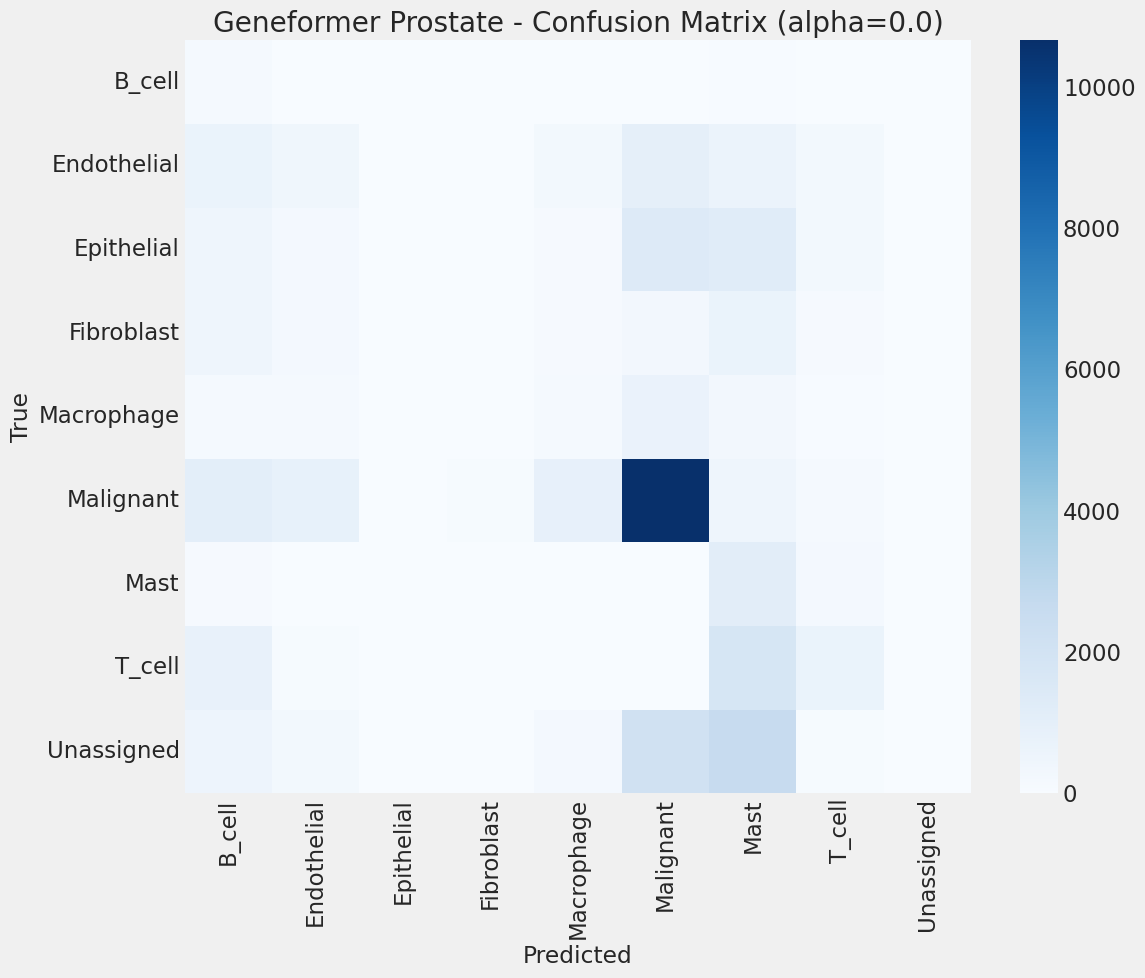

In [13]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(em.labels_encoded, preds)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=em.class_names,
            yticklabels=em.class_names, ax=ax)
ax.set_title(f'Geneformer Prostate - Confusion Matrix (alpha={best_alpha})')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
cm_png = MODEL_OUT / f'geneformer_prostate_confusion_matrix_model_v1_{RUN_TAG}.png'
plt.savefig(cm_png, dpi=200)
print('Saved confusion matrix to:', cm_png)


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs/geneformer_prostate_umap_coords_model_v1_full.csv


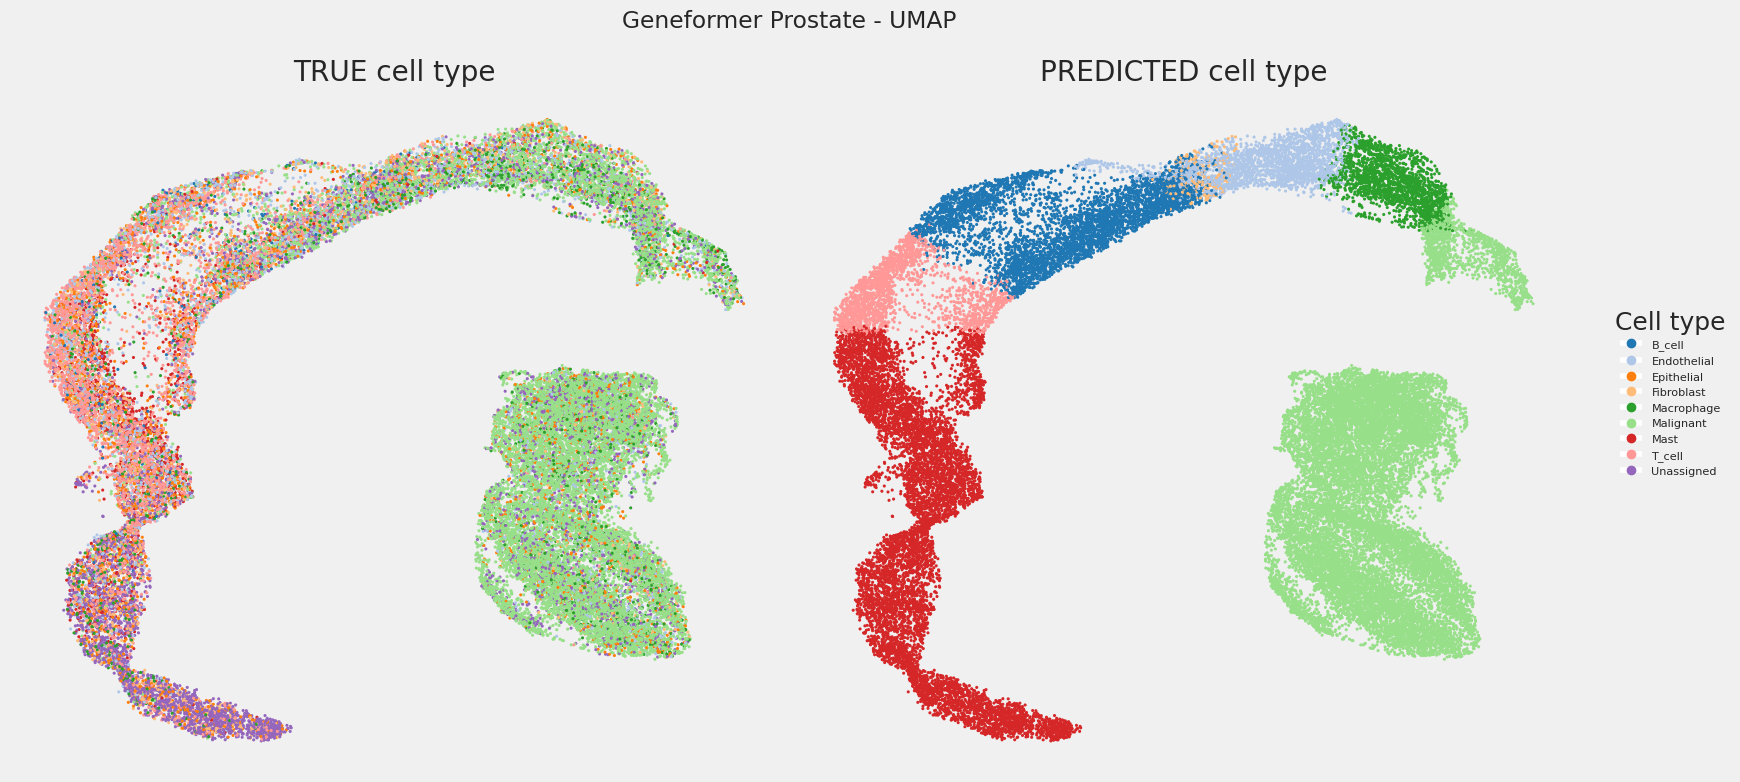

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs/geneformer_prostate_umap_true_pred_with_legend_model_v1_full.png


In [14]:
# UMAP of true vs predicted labels with side legend
import numpy as np
import pandas as pd

embeddings = np.asarray(em.embeddings)
labels_encoded = np.asarray(em.labels_encoded)
class_names = list(em.class_names)
preds_arr = np.asarray(preds)

try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(embeddings)
    method_used = 'UMAP'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_names_arr = np.array(class_names, dtype=object)
true_names = class_names_arr[labels_encoded]
pred_names = class_names_arr[preds_arr]

PLOT_MAX = 50000
rng = np.random.RandomState(0)
plot_idx = np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False)) if emb2d.shape[0] > PLOT_MAX else np.arange(emb2d.shape[0])

unique_levels = list(class_names)
if len(unique_levels) <= 20:
    pal_colors = sns.color_palette('tab20', n_colors=len(unique_levels))
else:
    pal_colors = sns.color_palette('hls', n_colors=len(unique_levels))
palette = dict(zip(unique_levels, pal_colors))

coords_path = MODEL_OUT / f'geneformer_prostate_umap_coords_model_v1_{RUN_TAG}.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE cell type'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED cell type'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in unique_levels
]
fig.legend(handles=handles, labels=unique_levels, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='xx-small', title='Cell type')
fig.suptitle(f'Geneformer Prostate - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_prostate_umap_true_pred_with_legend_model_v1_{RUN_TAG}.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)


In [15]:
# Performance metrics summary
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
)

results_path = MODEL_OUT / f'geneformer_prostate_results_model_v1_{RUN_TAG}.pt'

res = None
try:
    from torch.serialization import safe_globals, add_safe_globals
    try:
        with safe_globals([np.core.multiarray._reconstruct]):
            res = torch.load(results_path, map_location='cpu')
        print('Loaded results with safe_globals allowlist')
    except Exception:
        add_safe_globals([np.core.multiarray._reconstruct])
        res = torch.load(results_path, map_location='cpu')
        print('Loaded results after add_safe_globals')
except Exception:
    pass
if res is None:
    res = torch.load(results_path, map_location='cpu', weights_only=False)
    print('Loaded results with weights_only=False')

model_name = res.get('model_name', 'UnknownModel')
dataset = res.get('dataset_name', 'UnknownDataset')
best_alpha = res.get('best_alpha', None)
class_names = list(res.get('class_names', []))

labels_t = res['labels']
preds_t = res['preds']
labels_np = labels_t.cpu().numpy() if hasattr(labels_t, 'cpu') else np.array(labels_t)
preds_np = preds_t.cpu().numpy() if hasattr(preds_t, 'cpu') else np.array(preds_t)

print(f'Model: {model_name}')
print(f'Dataset: {dataset}')
if best_alpha is not None:
    print(f'Best alpha (ensemble): {best_alpha}')

metrics = res.get('evaluation_metrics', None)
if metrics is not None:
    print('\nSaved evaluation metrics:')
    for k in ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc', 'avg_precision']:
        if k in metrics:
            print(f'  {k}: {metrics[k]:.4f}')
else:
    acc = accuracy_score(labels_np, preds_np)
    prec, rec, f1, _ = precision_recall_fscore_support(labels_np, preds_np, average='macro', zero_division=0)
    print('\nComputed metrics (macro):')
    print(f'  accuracy: {acc:.4f}')
    print(f'  precision: {prec:.4f}')
    print(f'  recall: {rec:.4f}')
    print(f'  f1_score: {f1:.4f}')

if class_names and len(class_names) > int(labels_np.max()):
    target_names = class_names
else:
    n_classes = int(max(labels_np.max(), preds_np.max())) + 1
    target_names = [f'Class_{i}' for i in range(n_classes)]

print('\nClassification report:')
print(classification_report(labels_np, preds_np, target_names=target_names, digits=4))


Loaded results with weights_only=False
Model: Geneformer-V1-10M
Dataset: prostate_cancer_with_celltypes_v3
Best alpha (ensemble): 0.0

Saved evaluation metrics:
  accuracy: 0.3661
  precision: 0.3254
  recall: 0.3661
  f1_score: 0.3284
  auc_roc: 0.7046
  avg_precision: 0.1927

Classification report:
              precision    recall  f1-score   support

      B_cell     0.0415    0.5963    0.0776       322
 Endothelial     0.1764    0.1275    0.1480      3278
  Epithelial     0.0000    0.0000    0.0000      3782
  Fibroblast     0.1346    0.0172    0.0306      2030
  Macrophage     0.1055    0.1202    0.1124      1714
   Malignant     0.6566    0.7455    0.6982     14291
        Mast     0.1256    0.7410    0.2148      1529
      T_cell     0.3533    0.1999    0.2554      3481
  Unassigned     0.0000    0.0000    0.0000      5997

    accuracy                         0.3661     36424
   macro avg     0.1771    0.2831    0.1708     36424
weighted avg     0.3254    0.3661    0.3284     